# Chapter 08 - Explainable AI (XAI) techniques 

Example of how attention visualization, saliency maps, and natural language explanations can be generated simply using Python

In [2]:
# Import required libraries for model, tokenizer, and visualization
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Setup the model and tokenizer
model_name = 'bert-base-uncased'  # Specify pre-trained model name
tokenizer = BertTokenizer.from_pretrained(model_name)  # Load tokenizer for model
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)  # Load BERT model for sequence classification with 2 labels


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# Tokenize input text
travel_query = "What are the best family-friendly travel destinations in Europe?"  # Example travel-related query
inputs = tokenizer(travel_query, return_tensors="pt", truncation=True, padding=True)  # Tokenize input query with padding and truncation
input_ids = inputs['input_ids']  # Extract token IDs for the input text


In [5]:
# Function to get attention scores from the model
def get_attention_scores(model, inputs):
    # Run model with input and extract attention scores
    outputs = model(**inputs, output_attentions=True)
    return outputs.attentions  # Return attention scores from all layers

In [6]:
# Function to visualize attention scores
def visualize_attention(attention_scores, tokens):
    sns.set(style='whitegrid')  # Set seaborn style for heatmap
    fig, ax = plt.subplots(figsize=(8, 8))  # Create a figure for plotting
    attention_layer = attention_scores[-1][0]  # Extract the last attention layer's scores
    attention_weights = attention_layer[0].detach().numpy()  # Convert attention scores to numpy array for plotting

    # Plot the attention heatmap
    sns.heatmap(attention_weights, xticklabels=tokens, yticklabels=tokens, cmap="viridis", ax=ax)
    plt.title("Attention Visualization")  # Title for the plot
    plt.show()  # Display the plot


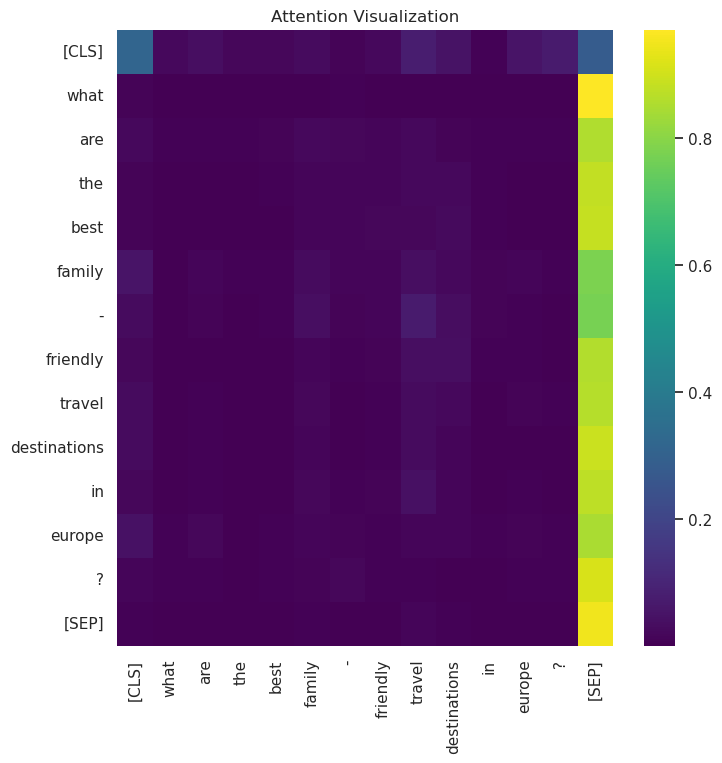

In [7]:
# Get attention scores from the model
attention_scores = get_attention_scores(model, inputs)

# Decode the input IDs to get human-readable tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

# Visualize the attention scores for the tokens in the input
visualize_attention(attention_scores, tokens)

## Saliency Maps

In [8]:
# Import necessary library for saliency map visualization
from captum.attr import Saliency

In [9]:
# Saliency Map Visualization function to visualize the importance of each token
def visualize_saliency(sentence):
    # Step 1: Tokenize the input sentence
    # Use the BERT tokenizer to convert the input sentence into token IDs and attention masks.
    # Attention mask ensures the padding tokens are ignored during processing.
    inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding=True)
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    # Step 2: Ensure the model is in evaluation mode
    # In evaluation mode, the model will not perform backpropagation (no parameter updates),
    # which is important for inference and visualizations.
    model.eval()
    
    # Step 3: Get embeddings and enable gradient tracking
    # Get the token embeddings from the model's input embedding layer and enable gradient tracking.
    # This allows the saliency map to be computed based on the gradients of the embeddings.
    embeddings = model.get_input_embeddings()(input_ids).requires_grad_()

    # Step 4: Define a custom forward function for the model
    # The forward function will process the embeddings directly and return the model's logits (predictions).
    # We bypass the usual model inputs to directly feed the embeddings for saliency calculation.
    def forward_with_logits(embeddings):
        return model(inputs_embeds=embeddings, attention_mask=attention_mask).logits

    # Step 5: Initialize Saliency and compute the saliency scores
    # Saliency scores measure the contribution of each token to the model's prediction.
    saliency = Saliency(forward_with_logits)
    
    # Get the saliency scores for the input embeddings with respect to the positive class (target=1)
    saliency_scores = saliency.attribute(embeddings, target=1)

    # Step 6: Convert token IDs back to human-readable tokens
    # This step helps us map the token IDs back into actual words for better interpretability.
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    
    # Step 7: Aggregate the saliency scores for visualization
    # Summing the saliency scores across the token's embedding dimension to get a single score for each token.
    # This helps in visualizing the importance of each token in a 2D plot.
    saliency_scores = saliency_scores.sum(dim=2).squeeze()

    # Step 8: Visualize the saliency map
    # Create a bar chart where each token's importance score is plotted, allowing us to see which tokens
    # are most important for the model's decision. Tokens on the x-axis and saliency scores on the y-axis.
    plt.bar(range(len(tokens)), saliency_scores.detach().numpy(), tick_label=tokens, color='teal')
    
    # Rotate x-axis labels for better readability of tokens
    plt.xticks(rotation=45)
    
    # Add a title to the plot
    plt.title("Saliency Map")
    
    # Display the plot
    plt.show

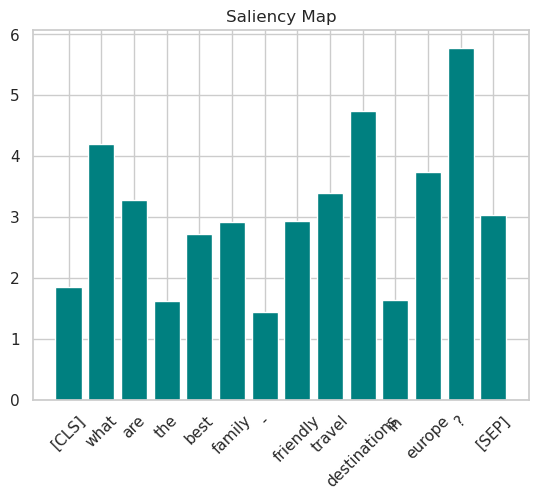

In [10]:
# Example input sentence
travel_query = "What are the best family-friendly travel destinations in Europe?"

# Example sentence to visualize saliency for
visualize_saliency(travel_query)

## Natural Language Explanations

In [15]:
!pip install openai --quiet

In [16]:
# Import the OpenAI library and os for accessing environment variables
from openai import OpenAI
import os

In [17]:
# Set the OpenAI API key directly in the notebook
os.environ["OPENAI_API_KEY"] = "YOUR-KEY"

In [18]:
# Function to generate an explanation using OpenAI
def generate_explanation_with_openai(text):
    # Initialize the OpenAI client with the API key stored in the environment variables
    client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

    # Use the OpenAI client to make a request for generating a completion (explanation)
    response = client.chat.completions.create(
        model="gpt-4o-mini",  # Specify the model to be used for generation
        messages=[  # Provide the context for the model
            {"role": "system", "content": "You are an explainability assistant."},  # System message setting the assistant's role
            {"role": "user", "content": f"Explain why '{text}' is important in the context of travel."}  # User query with the input text
        ]
    )

    # Extract the generated explanation from the response object
    explanation = response.choices[0].message.content

    # Return the explanation text
    return explanation

# Example usage: calling the function with a sample input
explanation = generate_explanation_with_openai(travel_query)

# Output the generated explanation
print(f"Explanation:\n{explanation}")


Explanation:
The question 'What are the best family-friendly travel destinations in Europe?' is significant for several reasons in the context of travel:

1. **Diverse Needs of Families**: Families traveling with children have unique requirements compared to solo travelers or couples. This includes considerations for safety, availability of kid-friendly activities, and accommodations that cater to families. Identifying the best destinations helps families plan trips that meet these specific needs.

2. **Quality Time and Bonding**: Family vacations provide essential opportunities for bonding and creating lasting memories. Finding destinations that offer activities and experiences suitable for all ages can enhance family dynamics and improve relationships.

3. **Educational Opportunities**: Europe is rich in history, culture, and art. Family-friendly travel destinations often incorporate educational components, allowing children to learn while having fun. This can enrich children's under